# Optical Character Recognition of Arabic Characters

Classifiying Arabic characters. For more details please visit [this link](https://www.kaggle.com/mloey1/ahdd1)

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Loading training dataset

In [2]:
# load training data
x_train = pd.read_csv('./dataset/csvTrainImages 13440x1024.csv')
print("Training images")
x_train.head()

# load training labels
y_train = pd.read_csv('./dataset/csvTrainLabel 13440x1.csv')
print("Training labels")
y_train.head()

# convert x_train dataframe to numpy ndarray and transpose each image using swapaxes.
x_train = x_train.values.reshape([-1,32,32]).swapaxes(1,2)

# convert y_train dataframe to numpy ndarray and remove all extra dimensions.
y_train = y_train.values.squeeze()

Training images
Training labels


### Loading test dataset

In [3]:
valid_test_split = 0.5

# load test data
x_test = pd.read_csv('./dataset/csvTestImages 3360x1024.csv')
x_test.head()
x_test = x_test.values.reshape([-1,32,32]).swapaxes(1,2)

# load test labels
y_test = pd.read_csv('./dataset/csvTestLabel 3360x1.csv')
y_test.head()
y_test = y_test.values.squeeze()

### Creating validation and test splits of the test set

In [4]:
m_test = y_test.shape[0]
x_val = x_test[ : int(m_test * valid_test_split) ]
x_test = x_test[ int(m_test * valid_test_split) : ]

y_val = y_test[ : int(m_test * valid_test_split) ]
y_test = y_test[ int(m_test * valid_test_split) : ]

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


x_train shape: (13439, 32, 32)
x_val shape: (1679, 32, 32)
x_test shape: (1680, 32, 32)
y_train shape: (13439,)
y_val shape: (1679,)
y_test shape: (1680,)


### Plotting random samples of the training set

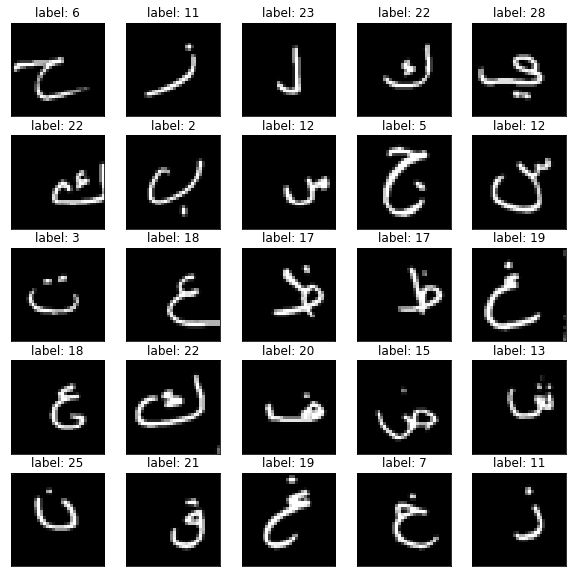

In [5]:
fig = plt.figure(0, figsize=(10,10))
indices = np.random.randint(0, y_train.shape[0], size=25)


for i, idx in enumerate(indices):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title("label: {}".format(y_train[idx]))
    plt.xticks([])
    plt.yticks([])
plt.show()

### Preprcoessing

In [6]:
# scaling features to range [0,1]
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

In [7]:
# change the dimensions of each image to 32x32x1
x_train = x_train[:,:,:,np.newaxis]
print(x_train.shape)
x_val = x_val[:,:,:,np.newaxis]
print(x_val.shape)
x_test = x_test[:,:,:,np.newaxis]
print(x_test.shape)

(13439, 32, 32, 1)
(1679, 32, 32, 1)
(1680, 32, 32, 1)


In [8]:
# changing the labels to one-hot encoding format (28 entry all zeros except for one)
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()
y_train = one_hot.fit_transform(y_train[:, None]).toarray()
y_val = one_hot.fit_transform(y_val[:, None]).toarray()
y_test = one_hot.fit_transform(y_test[:, None]).toarray()

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(13439, 28)
(1679, 28)
(1680, 28)


### Building the classification model

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout

classifier = Sequential()
classifier.add(Conv2D(16, 5, strides=1, padding='valid', activation='relu', input_shape=[32, 32, 1]))
# classifier.add(BatchNormalization(axis=2))

classifier.add(Conv2D(32, 2, strides=2, padding='valid', activation='relu'))
classifier.add(BatchNormalization(axis=3))

classifier.add(Conv2D(64, 5, strides=1, padding='valid', activation='relu'))
classifier.add(BatchNormalization(axis=3))

classifier.add(Conv2D(128, 2, strides=2, padding='valid', activation='relu'))
classifier.add(BatchNormalization(axis=3))

classifier.add(GlobalAveragePooling2D())

classifier.add(Dropout(rate=0.4))
classifier.add(Dense(128, activation='relu'))
classifier.add(BatchNormalization(axis=1))

classifier.add(Dropout(rate=0.3))
classifier.add(Dense(28, activation='softmax'))

classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 128)         512       
__________

### Training the model

In [10]:
# creating a ModelCheckpoint object to store the best model's parameters
from keras.callbacks import ModelCheckpoint
chkpt = ModelCheckpoint('arabic_ocr_best_weights.md5', verbose=0, save_best_only=True)

# start training
history = classifier.fit(x_train,
                           y_train,
                           batch_size=256,
                           epochs=50,
                           verbose=2,
                           validation_data=(x_val, y_val),
                           callbacks=[chkpt])

Train on 13439 samples, validate on 1679 samples
Epoch 1/50
4s - loss: 2.7860 - acc: 0.2175 - val_loss: 3.3425 - val_acc: 0.0357
Epoch 2/50
1s - loss: 1.5422 - acc: 0.4979 - val_loss: 3.5638 - val_acc: 0.0357
Epoch 3/50
1s - loss: 1.0113 - acc: 0.6706 - val_loss: 4.4703 - val_acc: 0.0357
Epoch 4/50
1s - loss: 0.7045 - acc: 0.7790 - val_loss: 6.5230 - val_acc: 0.0357
Epoch 5/50
1s - loss: 0.5450 - acc: 0.8274 - val_loss: 7.5775 - val_acc: 0.0357
Epoch 6/50
1s - loss: 0.4306 - acc: 0.8687 - val_loss: 8.9973 - val_acc: 0.0357
Epoch 7/50
1s - loss: 0.3704 - acc: 0.8872 - val_loss: 8.9296 - val_acc: 0.0482
Epoch 8/50
1s - loss: 0.2980 - acc: 0.9126 - val_loss: 9.6102 - val_acc: 0.0476
Epoch 9/50
1s - loss: 0.2583 - acc: 0.9238 - val_loss: 8.3181 - val_acc: 0.0929
Epoch 10/50
1s - loss: 0.2319 - acc: 0.9306 - val_loss: 6.8443 - val_acc: 0.1650
Epoch 11/50
1s - loss: 0.2086 - acc: 0.9381 - val_loss: 4.7185 - val_acc: 0.2168
Epoch 12/50
1s - loss: 0.1849 - acc: 0.9458 - val_loss: 1.8582 - val_

In [11]:
ev = classifier.evaluate(x_test, y_test)
print()
print(classifier.metrics_names[0], ev[0])
print(classifier.metrics_names[1], ev[1])

1680/1680 [==============================] - 0s     

loss 0.204651027617
acc 0.953571428571


### Plotting Accuracy VS Epochs

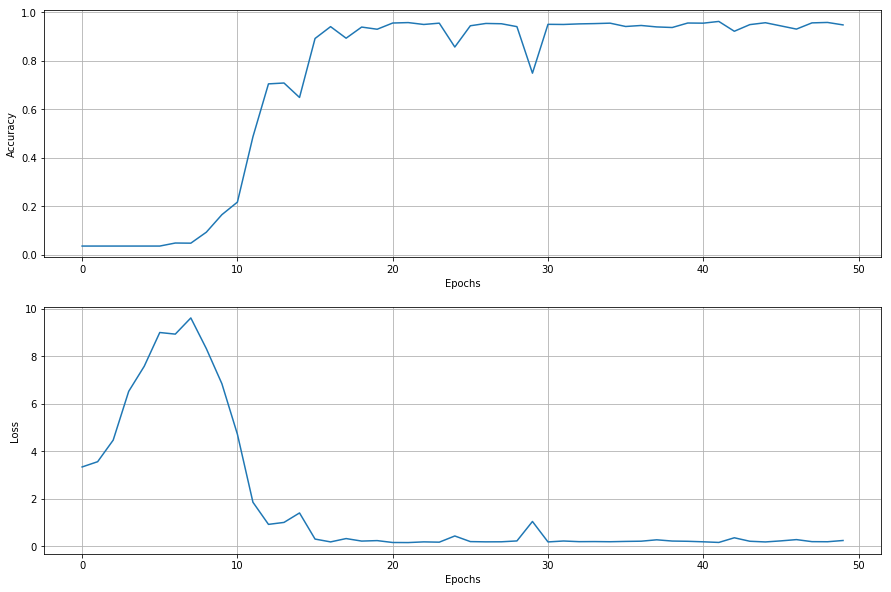

In [14]:
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

fig = plt.figure(1, figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.subplot(2,1,2)
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()

plt.show()

### Plotting random test samples with their predicted labels and true labels

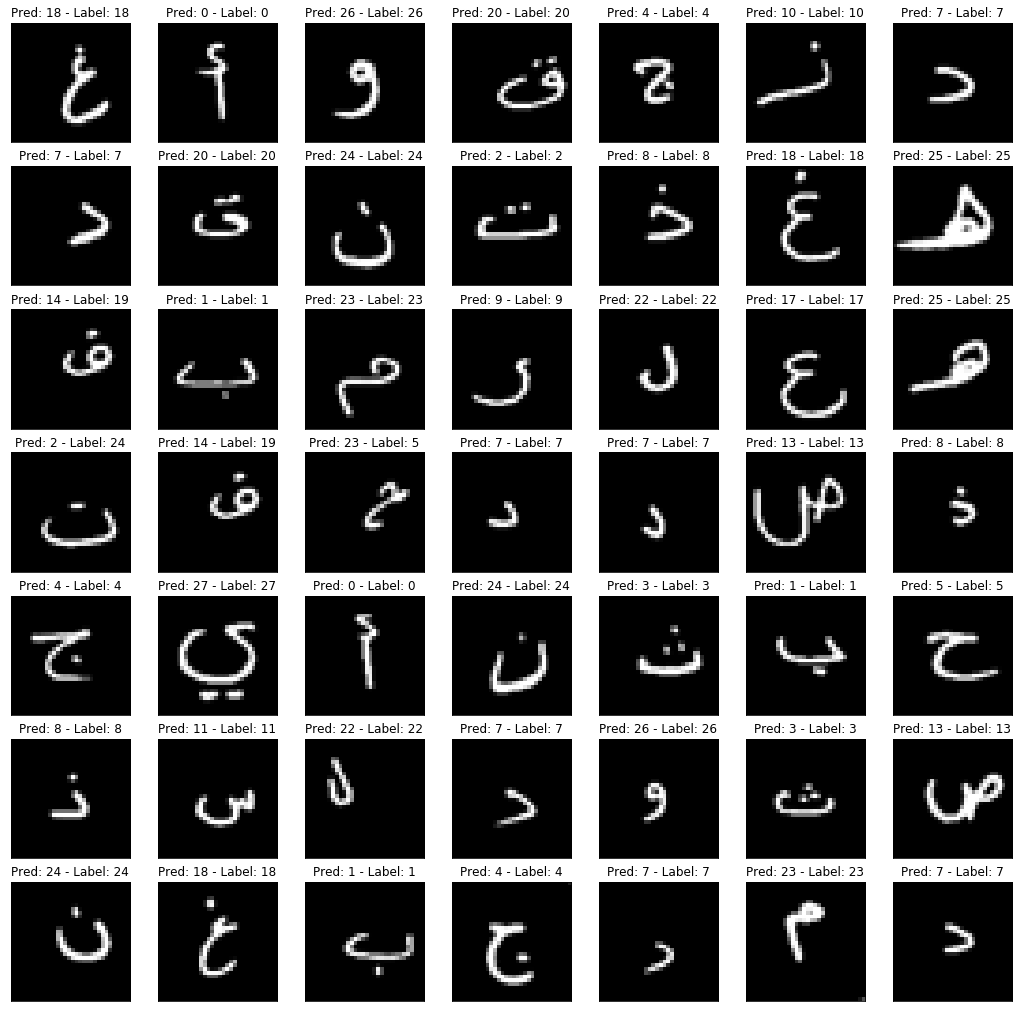

In [13]:
fig = plt.figure(0, figsize=(18,18))
indices = np.random.randint(0, y_test.shape[0], size=49)
y_pred = np.argmax(classifier.predict(x_test), axis=1)

for i, idx in enumerate(indices):
    plt.subplot(7,7,i+1)
    plt.imshow(x_test[idx][:,:,0], cmap='gray')
    plt.title("Pred: {} - Label: {}".format(y_pred[idx], np.argmax(y_test[idx])))
    plt.xticks([])
    plt.yticks([])
plt.show()